In [24]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Parameters
kappa = 0.1  # Matern parameter
n = 50
p = 200  # Number of spatial points
batches = 30  # Number of simulations
grid = np.linspace(0, 1, p)  # 1D spatial grid

# Correct covariance function for Matern SPDE with nu=1/2
def matern_cov(x, h, kappa):
    return (kappa / 2) * np.exp(-np.abs(h) / kappa)

# Generate samples from Matern process (Ornstein-Uhlenbeck process for nu=1/2)
def simulate_matern_1d(kappa, p, grid, n):
    cov_matrix = np.zeros((p, p))
    for i in range(p):
        for j in range(p):
            cov_matrix[i, j] = matern_cov(grid[i], grid[j] - grid[i], kappa)
    # Simulate the process using multivariate Gaussian
    return np.random.multivariate_normal(np.zeros(p), cov_matrix, size=n)

# True correlation vector with the last point
true_cov = np.array([matern_cov(0, grid[-1] - grid[i], kappa) for i in range(p)])
true_corr = true_cov / np.sqrt(true_cov[-1] **2 )

# Simulate B realizations of Matern samples
cross_corr_estimates = np.zeros((batches, p))

for b in range(batches):
    # Generate a realization of Matern process
    U = simulate_matern_1d(kappa, p, grid, n)
    
    # Calculate correlation between first and last points
    for i in range(p):
        cov = np.cov(U[:,-1], U[:,i])[0, 1]
        std_last = np.std(U[:,-1])
        std_i = np.std(U[:,i])
        cross_corr_estimates[b, i] = cov / (std_last * std_i)

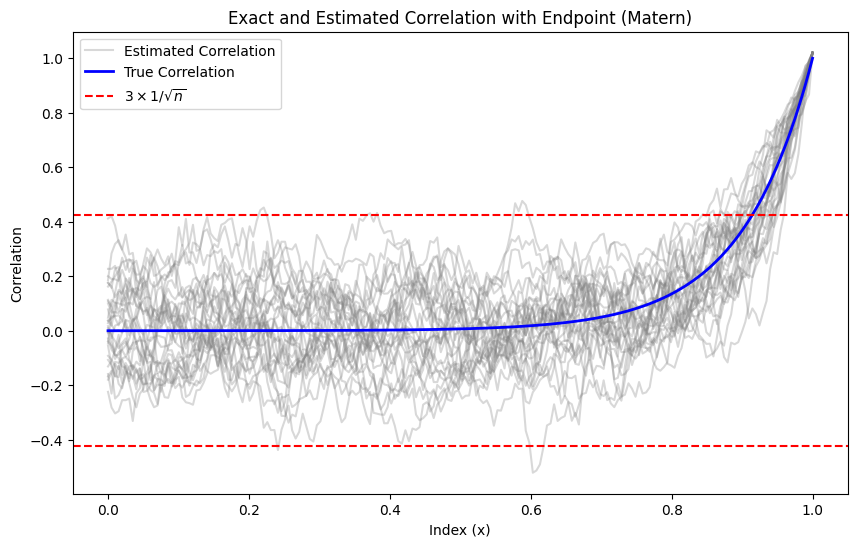

In [25]:
# Plot results
plt.figure(figsize=(10, 6))
for b in range(batches):
    plt.plot(grid, cross_corr_estimates[b, :], color='gray', alpha=0.3, label='Estimated Correlation' if b == 0 else "")

plt.plot(grid, true_corr, color='blue', label='True Correlation', linewidth=2)

# Horizontal lines at +- 3 * 1/np.sqrt(n)
threshold = 3 * 1 / np.sqrt(n)
plt.axhline(y=threshold, color='red', linestyle='--', label=r'$3 \times 1/\sqrt{n}$')
plt.axhline(y=-threshold, color='red', linestyle='--')

plt.xlabel('Index (x)')
plt.ylabel('Correlation')
plt.title('Exact and Estimated Correlation with Endpoint (Matern)')
plt.legend()
plt.show()

In [26]:
if False:
    # Set figure size appropriate for a paper (in inches)
    plt.figure(figsize=(7, 3))  # Example small figure size for papers
    
    # Plot the results again but directed at the PDF output
    for b in range(B):
        plt.plot(grid, cross_corr_estimates[b, :], color='gray', alpha=0.3)
    
    plt.plot(grid, true_corr, color='blue', label='True Correlation', linewidth=2)
    
    # Horizontal lines at +- 3 * 1/np.sqrt(n)
    threshold = 3 * 1 / np.sqrt(n)
    plt.axhline(y=threshold, color='red', linestyle='--', label=r'$3 \times 1/\sqrt{n}$')
    plt.axhline(y=-threshold, color='red', linestyle='--')
    
    plt.xlabel('Space (x)')
    plt.ylabel('Correlation')
    plt.title('Exact and Estimated (Matern) Correlation with Endpoint')
    plt.legend()
    
    # Save figure to PDF with high quality
    #plt.savefig("matern_correlation_plot.pdf", format='pdf', bbox_inches='tight')
    
    plt.close()  # Close the plot to avoid displaying it again


In [27]:
# Parameters
kappa = 0.1  # Matern parameter
n = 50
p = 200  # Number of spatial points
B = 50  # Number of simulations
grid = np.linspace(0, 1, p)  # 1D spatial grid
d_T = 3.0  # Observation of the last point


# Simulate B realizations of Matern samples
prior_realizations = np.zeros((B, p))

true_cov = np.array([matern_cov(0, grid[-1] - grid[i], kappa) for i in range(p)])

for b in range(B):
    # Generate a realization of Matern process
    U = simulate_matern_1d(kappa, p, grid, 1)  # Simulate one realization
    prior_realizations[b, :] = U.flatten()



# Variance at the last point
var_T = true_cov[-1]

# Update each realization conditioned on d_T
posterior_realizations = np.copy(prior_realizations)
for b in range(B):
    u_T_b = prior_realizations[b, -1]  # The last point of the current realization
    for i in range(p):
        posterior_realizations[b, i] = prior_realizations[b, i] + true_cov[i] / var_T * (d_T - u_T_b)

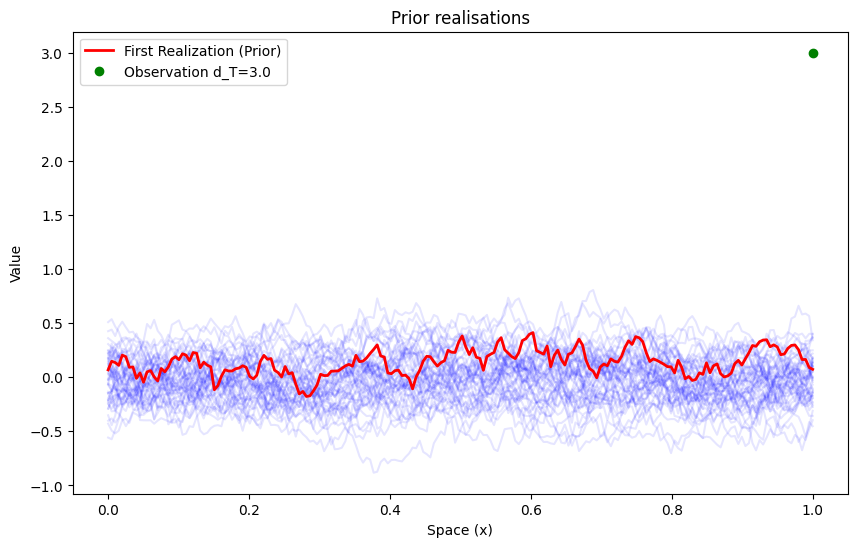

In [28]:
# Plot prior realizations with the observation
plt.figure(figsize=(10, 6))

# Plot prior realizations in blue with transparency
for b in range(B):
    plt.plot(grid, prior_realizations[b, :], color='blue', alpha=0.1)

plt.plot(grid, prior_realizations[0, :], color='red', linewidth=2, label='First Realization (Prior)')

# Plot the observation as a green dot
plt.plot(grid[-1], d_T, 'go', label=f'Observation d_T={d_T}')

plt.xlabel('Space (x)')
plt.ylabel('Value')
plt.title('Prior realisations')
plt.legend()

if False:
    plt.savefig("matern_prior_plot.pdf", format='pdf', bbox_inches='tight')

plt.show()
plt.close()

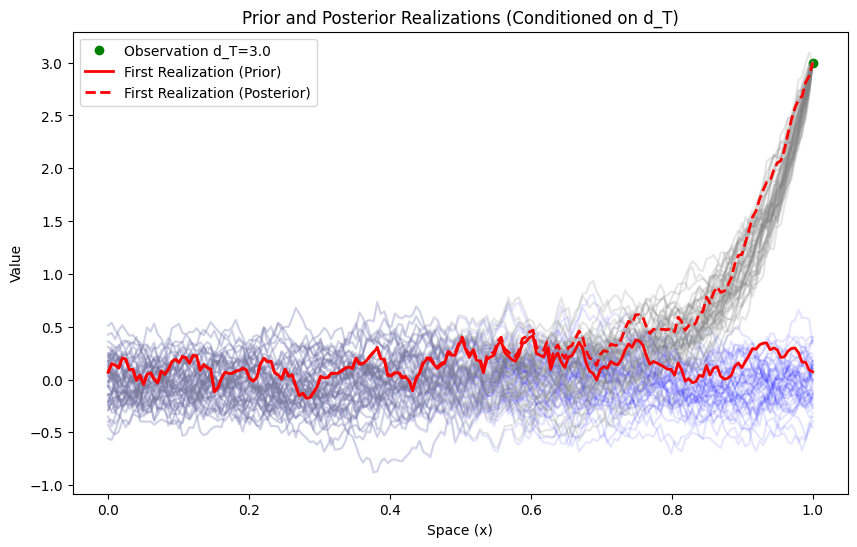

In [29]:
# Overlay posterior realizations on top of the prior plot
plt.figure(figsize=(10, 6))

# Plot prior realizations in blue again
for b in range(B):
    plt.plot(grid, prior_realizations[b, :], color='blue', alpha=0.1)

# Plot the observation as a green dot again
plt.plot(grid[-1], d_T, 'go', label=f'Observation d_T={d_T}')

# Plot posterior realizations in gray with transparency
for b in range(B):
    plt.plot(grid, posterior_realizations[b, :], color='gray', alpha=0.2)

plt.plot(grid, prior_realizations[0, :], color='red', linewidth=2, label='First Realization (Prior)')
plt.plot(grid, posterior_realizations[0, :], color='red', linewidth=2, linestyle='--', label='First Realization (Posterior)')


plt.xlabel('Space (x)')
plt.ylabel('Value')
plt.title('Prior and Posterior Realizations (Conditioned on d_T)')
plt.legend()

if False:
    plt.savefig("matern_prior_posterior_plot.pdf", format='pdf', bbox_inches='tight')

plt.show()
plt.close()

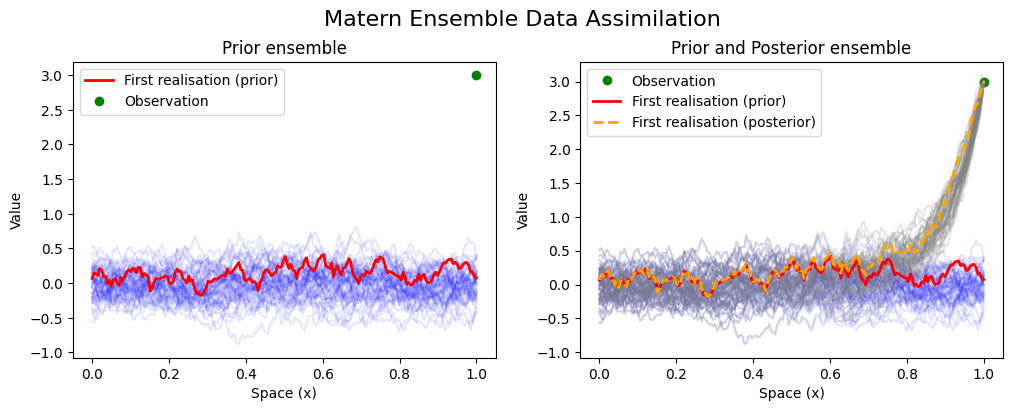

In [30]:
import matplotlib.pyplot as plt

# Create a figure with two subplots (horizontally aligned)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot prior realizations with the observation (left subplot)
for b in range(B):
    axs[0].plot(grid, prior_realizations[b, :], color='blue', alpha=0.1)

axs[0].plot(grid, prior_realizations[0, :], color='red', linewidth=2, label='First realisation (prior)')
axs[0].plot(grid[-1], d_T, 'go', label=f'Observation')

axs[0].set_xlabel('Space (x)')
axs[0].set_ylabel('Value')
axs[0].set_title('Prior ensemble')
axs[0].legend()

# Plot posterior realizations (right subplot)
for b in range(B):
    axs[1].plot(grid, prior_realizations[b, :], color='blue', alpha=0.1)

axs[1].plot(grid[-1], d_T, 'go', label=f'Observation')

for b in range(B):
    axs[1].plot(grid, posterior_realizations[b, :], color='gray', alpha=0.2)

axs[1].plot(grid, prior_realizations[0, :], color='red', linewidth=2, label='First realisation (prior)')
axs[1].plot(grid, posterior_realizations[0, :], color='orange', linewidth=2, linestyle='--', label='First realisation (posterior)')

axs[1].set_xlabel('Space (x)')
axs[1].set_ylabel('Value')
axs[1].set_title('Prior and Posterior ensemble')
axs[1].legend()

# Set the overall title
fig.suptitle('Matern Ensemble Data Assimilation', fontsize=16)

# Adjust spacing to provide more room between the main title and subplots
fig.subplots_adjust(top=0.85)

# Save the figure as a PDF
if True:
    plt.savefig("matern_ensemble_data_assimilation.pdf", format='pdf', bbox_inches='tight')

plt.show()


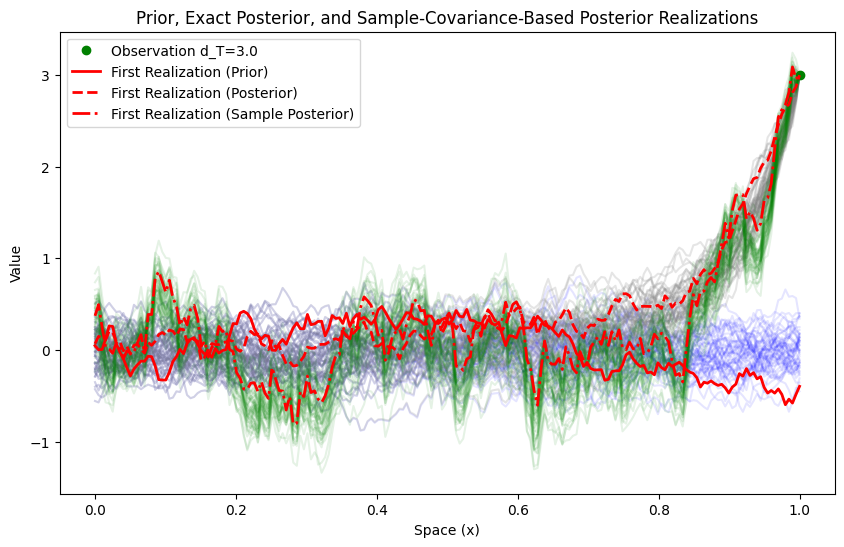

In [31]:
# Simulate a new set of posterior realizations based on the sample covariance
sample_posterior_realizations = np.copy(prior_realizations)
first_realisation_cov = np.zeros((p,))

for b in range(B):
    # Use the sample covariance instead of the exact covariance
    U_sample = prior_realizations  # The prior realizations are used as samples
    cov_sample_T = np.cov(U_sample[:, -1], rowvar=False)  # Sample covariance at last point
    var_T_sample = cov_sample_T #[-1, -1]  # Variance at the last point based on the sample

    # Update using the sample covariance
    for i in range(p):
        cov_sample = np.cov(U_sample[:, i], U_sample[:, -1])[0, 1]  # Sample cross-covariance
        sample_posterior_realizations[b, i] = prior_realizations[b, i] + cov_sample / var_T_sample * (d_T - prior_realizations[b, -1])
        if b==0:
            first_realisation_cov[i] = np.corrcoef(U_sample[:, i], U_sample[:, -1])[0, 1]

# Overlay the third set of posterior realizations based on the sample covariance
plt.figure(figsize=(10, 6))

# Plot prior realizations in blue
for b in range(B):
    if b == 0:
        pass
    else:
        plt.plot(grid, prior_realizations[b, :], color='blue', alpha=0.1)

# Plot posterior realizations in gray
for b in range(B):
    if b == 0:
        pass
    else:
        plt.plot(grid, posterior_realizations[b, :], color='gray', alpha=0.2)

# Plot the observation as a green dot
plt.plot(grid[-1], d_T, 'go', label=f'Observation d_T={d_T}')

# Plot the new posterior realizations based on the sample covariance in green
for b in range(B):
    if b == 0:
        pass
    else:
        plt.plot(grid, sample_posterior_realizations[b, :], color='green', alpha=0.1)

# Plot first realizations in red, strong
plt.plot(grid, prior_realizations[b, :], color='red', linewidth=2, label='First Realization (Prior)')
plt.plot(grid, posterior_realizations[0, :], color='red', linewidth=2, linestyle='--', label='First Realization (Posterior)')
plt.plot(grid, sample_posterior_realizations[0, :], color='red', linewidth=2, linestyle='-.', label='First Realization (Sample Posterior)')

plt.xlabel('Space (x)')
plt.ylabel('Value')
plt.title('Prior, Exact Posterior, and Sample-Covariance-Based Posterior Realizations')
plt.legend()

if False:
    plt.savefig("matern_prior_posterior_sample_plot.pdf", format='pdf', bbox_inches='tight')

plt.show()
plt.close()

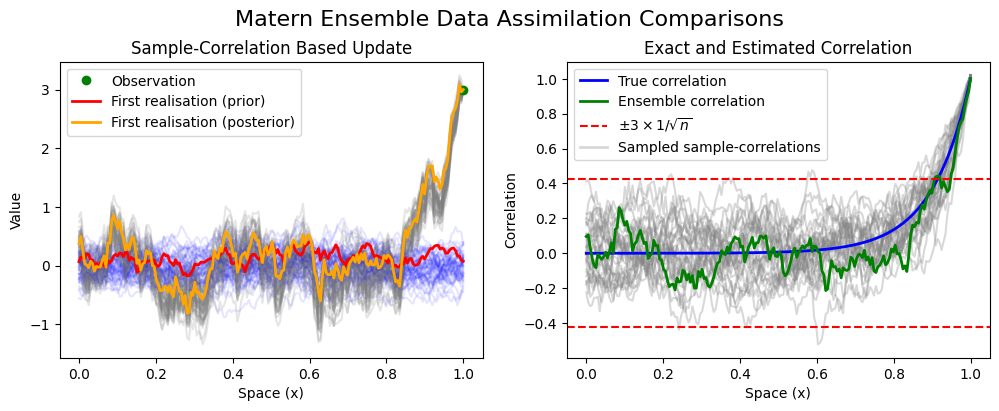

In [32]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines


# Create a figure with three subplots (horizontally aligned)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# First subplot: Prior, Exact Posterior, and Sample-Covariance-Based Posterior Realizations
for b in range(B):
    if b != 0:
        axs[0].plot(grid, prior_realizations[b, :], color='blue', alpha=0.1)
        #axs[0].plot(grid, posterior_realizations[b, :], color='gray', alpha=0.2)
        axs[0].plot(grid, sample_posterior_realizations[b, :], color='gray', alpha=0.2)

axs[0].plot(grid[-1], d_T, 'go', label=f'Observation')

# Plot first realization
axs[0].plot(grid, prior_realizations[0, :], color='red', linewidth=2, label='First realisation (prior)')
#axs[0].plot(grid, posterior_realizations[0, :], color='red', linewidth=2, linestyle='--', label='First Realisation (Posterior)')
axs[0].plot(grid, sample_posterior_realizations[0, :], color='orange', linewidth=2, linestyle='-', label='First realisation (posterior)')

axs[0].set_xlabel('Space (x)')
axs[0].set_ylabel('Value')
axs[0].set_title('Sample-Correlation Based Update')
axs[0].legend()

# Second subplot: Exact and Estimated Correlation with Endpoint
for b in range(batches):
    axs[1].plot(grid, cross_corr_estimates[b, :], color='gray', alpha=0.3)

axs[1].plot(grid, true_corr, color='blue', label='True correlation', linewidth=2)
axs[1].plot(grid, first_realisation_cov, color='green', linewidth=2, linestyle='-', label='Ensemble correlation')

# Horizontal lines at +- 3 * 1/np.sqrt(n)
threshold = 3 * 1 / np.sqrt(n)
axs[1].axhline(y=threshold, color='red', linestyle='--', label=r'$\pm 3 \times 1/\sqrt{n}$')
axs[1].axhline(y=-threshold, color='red', linestyle='--')

axs[1].set_xlabel('Space (x)')
axs[1].set_ylabel('Correlation')
axs[1].set_title('Exact and Estimated Correlation')
axs[1].legend()
# Add a custom legend entry for the loop-plotted lines
sample_legend = mlines.Line2D([], [], color='gray', alpha=0.3, linewidth=2, label='Sampled sample-correlations')
axs[1].legend(handles=axs[1].get_legend_handles_labels()[0] + [sample_legend])

# Adjust spacing to provide more room between the main title and subplots
fig.subplots_adjust(top=0.85)

# Set the overall title
fig.suptitle('Matern Ensemble Data Assimilation Comparisons', fontsize=16)

# Save the figure as a PDF
if True:
    plt.savefig("matern_ensemble_data_assimilation_comparison.pdf", format='pdf', bbox_inches='tight')

plt.show()


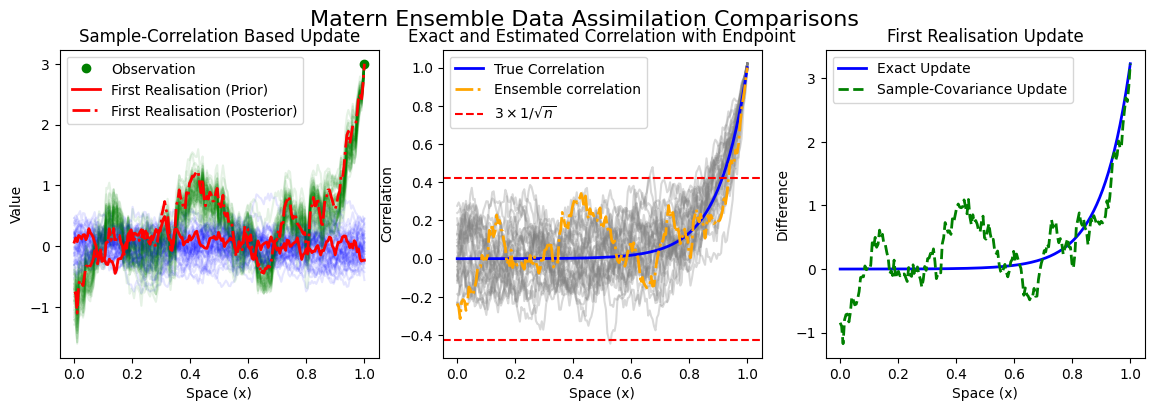

In [14]:
import matplotlib.pyplot as plt

# Create a figure with three subplots (horizontally aligned)
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

# First subplot: Prior, Exact Posterior, and Sample-Covariance-Based Posterior Realizations
for b in range(B):
    if b != 0:
        axs[0].plot(grid, prior_realizations[b, :], color='blue', alpha=0.1)
        #axs[0].plot(grid, posterior_realizations[b, :], color='gray', alpha=0.2)
        axs[0].plot(grid, sample_posterior_realizations[b, :], color='green', alpha=0.1)

axs[0].plot(grid[-1], d_T, 'go', label=f'Observation')

# Plot first realization
axs[0].plot(grid, prior_realizations[0, :], color='red', linewidth=2, label='First Realisation (Prior)')
#axs[0].plot(grid, posterior_realizations[0, :], color='red', linewidth=2, linestyle='--', label='First Realisation (Posterior)')
axs[0].plot(grid, sample_posterior_realizations[0, :], color='red', linewidth=2, linestyle='-.', label='First Realisation (Posterior)')

axs[0].set_xlabel('Space (x)')
axs[0].set_ylabel('Value')
axs[0].set_title('Sample-Correlation Based Update')
axs[0].legend()

# Second subplot: Exact and Estimated Correlation with Endpoint
for b in range(batches):
    axs[1].plot(grid, cross_corr_estimates[b, :], color='gray', alpha=0.3)

axs[1].plot(grid, true_corr, color='blue', label='True Correlation', linewidth=2)
axs[1].plot(grid, first_realisation_cov, color='orange', linewidth=2, linestyle='-.', label='Ensemble correlation')

# Horizontal lines at +- 3 * 1/np.sqrt(n)
threshold = 3 * 1 / np.sqrt(n)
axs[1].axhline(y=threshold, color='red', linestyle='--', label=r'$3 \times 1/\sqrt{n}$')
axs[1].axhline(y=-threshold, color='red', linestyle='--')

axs[1].set_xlabel('Space (x)')
axs[1].set_ylabel('Correlation')
axs[1].set_title('Exact and Estimated Correlation with Endpoint')
axs[1].legend()

# Third subplot: Exact posterior - prior and correlation-based posterior - prior for first realization
first_realisation_diff_exact = posterior_realizations[0, :] - prior_realizations[0, :]
first_realisation_diff_sample = sample_posterior_realizations[0, :] - prior_realizations[0, :]

# Plot the differences
axs[2].plot(grid, first_realisation_diff_exact, color='blue', linewidth=2, label='Exact Update')
axs[2].plot(grid, first_realisation_diff_sample, color='green', linewidth=2, linestyle='--', label='Sample-Covariance Update')

axs[2].set_xlabel('Space (x)')
axs[2].set_ylabel('Difference')
axs[2].set_title('First Realisation Update')
axs[2].legend()

# Set the overall title
fig.suptitle('Matern Ensemble Data Assimilation Comparisons', fontsize=16)

# Save the figure as a PDF
#plt.savefig("matern_ensemble_data_assimilation_comparison.pdf", format='pdf', bbox_inches='tight')

plt.show()


# GIF Making

## Exact Matern

In [180]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

# Number of realizations to plot
num_realizations_to_plot = 5  # You can change this to 10 if you prefer

# Set up figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Initial plot setup for first 5 (or 10) realizations
line_objects_prior = [ax.plot([], [], color='blue', alpha=1.0)[0] for _ in range(num_realizations_to_plot)]
line_objects_posterior = [ax.plot([], [], color='orange', alpha=1.0)[0] for _ in range(num_realizations_to_plot)]  # Different color for posterior
ax.plot(grid[-1], d_T, 'gX', markersize=10, label=f'Observation')
ax.set_xlabel('Space (x)')
ax.set_ylabel('Value')
ax.set_title('Monte Carlo Prior, Observation and Update to Posterior')
ax.legend()

# Set the axis limits based on the range of grid and realizations
ax.set_xlim(grid[0], grid[-1] + 0.1)
ax.set_ylim(np.min(prior_realizations), np.max([np.max(prior_realizations), d_T + 1.0]))

# Define the number of total frames
total_frames = len(grid) + 150  # Extra 20 frames for the posterior to be displayed

# Animation function: update the data for each frame (grid point)
def animate(i):
    if i < len(grid):  # Prior realizations over the grid points
        for b, line in enumerate(line_objects_prior):
            line.set_data(grid[:i+1], prior_realizations[b, :i+1])
    elif i == len(grid):  # Pause after the prior is done
        time.sleep(0.5)  # Pause for 0.5 seconds before switching to posterior
    else:  # Display the posterior realizations on top of the prior
        for b, line in enumerate(line_objects_posterior):
            line.set_data(grid, posterior_realizations[b, :])  # Show the entire posterior instantly

    return line_objects_prior + line_objects_posterior

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=total_frames, interval=35, blit=True)

# Save the animation as a GIF with 0.5s pause between transitions
ani.save('prior_to_posterior_realisations.gif', writer='imagemagick')

plt.close()


MovieWriter imagemagick unavailable; using Pillow instead.


## Exact vs ES

In [181]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

# Number of realizations to plot
num_realizations_to_plot = 5  # You can change this to 10 if you prefer

# Set up figure and axis
fig, ax = plt.subplots(figsize=(7, 4))

# Initial plot setup for first 5 (or 10) realizations
line_objects_prior = [ax.plot([], [], color='blue', alpha=1.0)[0] for _ in range(num_realizations_to_plot)]
line_objects_posterior = [ax.plot([], [], color='orange', alpha=1.0)[0] for _ in range(num_realizations_to_plot)]  # Different color for posterior
ax.plot(grid[-1], d_T, 'gX', markersize=10, label=f'Observation')
ax.set_xlabel('Space (x)')
ax.set_ylabel('Value')
ax.set_title('Analytical Exact Update')
ax.legend()

# Set the axis limits based on the range of grid and realizations
ax.set_xlim(grid[0], grid[-1] + 0.1)
ax.set_ylim(np.min(prior_realizations), np.max([np.max(prior_realizations), d_T + 1.0]))

# Define the number of total frames
total_frames = len(grid) + 150  # Extra 20 frames for the posterior to be displayed

# Animation function: update the data for each frame (grid point)
def animate(i):
    if i < len(grid):  # Prior realizations over the grid points
        for b, line in enumerate(line_objects_prior):
            line.set_data(grid[:i+1], prior_realizations[b, :i+1])
    elif i == len(grid):  # Pause after the prior is done
        time.sleep(0.5)  # Pause for 0.5 seconds before switching to posterior
    else:  # Display the posterior realizations on top of the prior
        for b, line in enumerate(line_objects_posterior):
            line.set_data(grid, posterior_realizations[b, :])  # Show the entire posterior instantly

    return line_objects_prior + line_objects_posterior

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=total_frames, interval=35, blit=True)

# Save the animation as a GIF with 0.5s pause between transitions
ani.save('prior_to_posterior_realisations_exact.gif', writer='imagemagick')

plt.close()


MovieWriter imagemagick unavailable; using Pillow instead.


In [182]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

# Number of realizations to plot
num_realizations_to_plot = 5  # You can change this to 10 if you prefer

# Set up figure and axis
fig, ax = plt.subplots(figsize=(7, 4))

# Initial plot setup for first 5 (or 10) realizations
line_objects_prior = [ax.plot([], [], color='blue', alpha=1.0)[0] for _ in range(num_realizations_to_plot)]
line_objects_posterior = [ax.plot([], [], color='orange', alpha=1.0)[0] for _ in range(num_realizations_to_plot)]  # Different color for posterior
ax.plot(grid[-1], d_T, 'gX', markersize=10, label=f'Observation')
ax.set_xlabel('Space (x)')
ax.set_ylabel('Value')
ax.set_title('Ensemble Smoother - Approximate Update')
ax.legend()

# Set the axis limits based on the range of grid and realizations
ax.set_xlim(grid[0], grid[-1] + 0.1)
ax.set_ylim(np.min(prior_realizations), np.max([np.max(prior_realizations), d_T + 1.0]))

# Define the number of total frames
total_frames = len(grid) + 150  # Extra 20 frames for the posterior to be displayed

# Animation function: update the data for each frame (grid point)
def animate(i):
    if i < len(grid):  # Prior realizations over the grid points
        for b, line in enumerate(line_objects_prior):
            line.set_data(grid[:i+1], prior_realizations[b, :i+1])
    elif i == len(grid):  # Pause after the prior is done
        time.sleep(0.5)  # Pause for 0.5 seconds before switching to posterior
    else:  # Display the posterior realizations on top of the prior
        for b, line in enumerate(line_objects_posterior):
            line.set_data(grid, sample_posterior_realizations[b, :])  # Show the entire posterior instantly

    return line_objects_prior + line_objects_posterior

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=total_frames, interval=35, blit=True)

# Save the animation as a GIF with 0.5s pause between transitions
ani.save('prior_to_posterior_realisations_es.gif', writer='imagemagick')

plt.close()


MovieWriter imagemagick unavailable; using Pillow instead.
